## Targeted Microbiome Restoration through F. Prausnitzii Gene Knockout Therapy

### Hannah Carroll

### BME 3990C Final Project

The code below will design a microbiome based therapeutic with the goal to restore a healthy gut in people who suffer from dysbiosis. There is a specific focus on this because the gut-brain axis is a relatively new discovery and is thought to play a key role in autoimmune disorders such as MS. See readme file for in depth analysis of code and results.

The design will use COBRApy (Metabolic Modeling) to target a bacteria: Faecalibacterium prausnitzii (producer of butyrate). It will determine the minimal media needed for F. prausnitzii to grow in. Some components will be added to the minimal media to create a more realistic environment. It will then individually knock out each gene and run FBA to see which has the highest production of butyrate exchange flux. Butyrate is an important SCFA that nourishes colonocytes and has anti-inflammatory properties. 

Parts of code adapted from notebooks created by D. Bernstein for his Microbiome Engineering course at UVM. 

In [77]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
#Imports
import numpy as np
import cobra as cb
import pandas as pd
import matplotlib.pyplot as plt

## Load *F. prausnitzii* Model

We will start by using a genome-scale metabolic model for *F. prausnitzii*. This model comes from the AGORA2 database which can be accessed through the vmh.life website. [Direct link to AGORA2 Models](https://www.vmh.life/files/reconstructions/AGORA2/version2.01/mat_files/individual_reconstructions/).

Use the link above to download the model for Faecalibacterium_prausnitzii_A2_165.mat. This is a matlab .mat file, it can be loaded into a python as a cobrapy model using the [load_matlab_model](https://cobrapy.readthedocs.io/en/latest/io.html#MATLAB) command.

In [19]:
FP_model = cb.io.load_matlab_model('Faecalibacterium_prausnitzii_A2_165.mat')

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


## Run Flux Balance Analysis for *F. prausnitzii* in Glucose Minimal Medium
Below, a minimal medium is defined to see what F. prausnitzii needs to grow on. FBA is run to confirm if F. prausnitzii is able to grow in this environment. 

Glucose and sulfate is then added to the environment to provide a more realistic environment. The parameter for glucose is set to -10 to limit the model. All other parameters are maxed at -100.

In [20]:
FP__minimal_medium = cb.medium.minimal_medium(FP_model, minimize_components=1)
print("Minimal Medium for F. prausnitzii:")
print(FP__minimal_medium)

Minimal Medium for F. prausnitzii:
EX_alaasp(e)         2.947527
EX_ca2(e)            0.000794
EX_cl(e)             0.000794
EX_cobalt2(e)        0.000794
EX_cspg_a_degr(e)    9.253552
EX_cu2(e)            0.000794
EX_fe2(e)            0.000794
EX_fe3(e)            0.000794
EX_fol(e)            0.002382
EX_glymet(e)         0.031430
EX_hxan(e)           0.015131
EX_k(e)              0.000794
EX_lys_L(e)          0.032370
EX_mg2(e)            0.000794
EX_mn2(e)            0.000794
EX_nac(e)            0.001588
EX_pi(e)             0.124214
EX_pnto_R(e)         0.001588
EX_pydx(e)           0.000794
EX_ribflv(e)         0.001588
EX_thm(e)            0.000794
EX_trp_L(e)          0.005450
EX_zn2(e)            0.000794
dtype: float64


In [5]:
#FP_min_med = ['EX_alaasp(e)','EX_ca2(e)','EX_cobalt2(e)','EX_cl(e)','EX_cspg_a_degr(e)','EX_cu2(e)','EX_fe2(e)',
#                 'EX_fe3(e)','EX_fol(e)','EX_glymet(e)','EX_hxan(e)','EX_k(e)','EX_lys_L(e)','EX_mg2(e)',
#                 'EX_mn2(e)', 'EX_nac(e)', 'EX_pi(e)', 'EX_pnto_R(e)', 'EX_pydx(e)', 'EX_ribflv(e)', 'EX_thm(e)', 
#                 'EX_trp_L(e)', 'EX_zn2(e)',]

# Define minimal medium with more realistic parameters - add glucose & sulfate
FP_min_med = ['EX_glc_D(e)','EX_ca2(e)','EX_cobalt2(e)','EX_cl(e)','EX_cu2(e)','EX_fe2(e)',
                 'EX_fe3(e)','EX_fol(e)','EX_glymet(e)','EX_hxan(e)','EX_k(e)','EX_lys_L(e)','EX_mg2(e)',
                 'EX_mn2(e)', 'EX_nac(e)', 'EX_pi(e)', 'EX_pnto_R(e)', 'EX_pydx(e)', 'EX_ribflv(e)', 'EX_thm(e)', 
                 'EX_trp_L(e)', 'EX_zn2(e)', 'EX_so4(e)','EX_alaasp(e)']

# Define medium uptake flux bounds, limit glucose uptake
FP_min_med_flux = [-10,-100,-100,-100,
                    -100,-100,-100,-100,
                    -100,-100,-100,-100,-100,
                    -100,-100,-100,-100,-100, 
                    -100,-100,-100,-100,-100,-100]

# Run FBA
with FP_model as model:
    # Turn off all uptake and allow all export
    for ex in model.exchanges:
        ex.lower_bound = 0
        ex.upper_bound = 1000

    # Add glucose minimal medium
    for i in range(len(FP_min_med)):
        model.exchanges.get_by_id(FP_min_med[i]).lower_bound = FP_min_med_flux[i]
    
    # Run flux balance analysis
    # parsimonious
    solution_knockout = cb.flux_analysis.parsimonious.pfba(model)
    print(model.summary())

Objective
1.0 biomass223 = 0.5674122525317109

Uptake
------
     Metabolite       Reaction      Flux  C-Number C-Flux
      alaasp[e]   EX_alaasp(e)     16.29         7 27.04%
         ca2[e]      EX_ca2(e)  0.004505         0  0.00%
          cl[e]       EX_cl(e)  0.004505         0  0.00%
     cobalt2[e]  EX_cobalt2(e)  0.004505         0  0.00%
         cu2[e]      EX_cu2(e)  0.004505         0  0.00%
         fe2[e]      EX_fe2(e)  0.004505         0  0.00%
         fe3[e]      EX_fe3(e)  0.004505         0  0.00%
         fol[e]      EX_fol(e)   0.01352        19  0.06%
       glc_D[e]    EX_glc_D(e)        10         6 14.22%
      glymet[e]   EX_glymet(e)    0.2256         7  0.37%
        hxan[e]     EX_hxan(e)   0.08586         5  0.10%
           k[e]        EX_k(e)  0.004505         0  0.00%
       lys_L[e]    EX_lys_L(e)    0.1837         6  0.26%
         mg2[e]      EX_mg2(e)  0.004505         0  0.00%
         mn2[e]      EX_mn2(e)  0.004505         0  0.00%
         na

## Perform gene knockouts
From the above data, we can see that butyrate is not being produced in the provided environment. Below, the code will run through all genes in the FP model and individually "knock them out". The butyrate exchange flux of each of these gene knockouts will be stored in an array. 

In [8]:
# define butyrate exchange reaction
butyrate_exchange_reaction = "EX_but(e)"

# Store the butyrate exchange fluxes for each gene knockout
fluxes = []
gene_knockouts = []

# Run FBA for no knockout 
with FP_model as model:
    # Turn off all uptake and allow all export
    for ex in model.exchanges:
        ex.lower_bound = 0
        ex.upper_bound = 1000

    # Add glucose minimal medium
    for i in range(len(FP_min_med)):
        model.exchanges.get_by_id(FP_min_med[i]).lower_bound = FP_min_med_flux[i]
        
    # determine the butyrate exchange flux for the model without any knockouts
    # Run FBA on the original model
    # parsimonious
    solution_no_knockouts = cb.flux_analysis.parsimonious.pfba(model)

    # Get the butyrate exchange flux for the model with no knockouts
    butyrate_flux_no_knockouts = solution_no_knockouts.fluxes.get(butyrate_exchange_reaction, 0)
    fluxes.append(butyrate_flux_no_knockouts)
    gene_knockouts.append('No Knockout')  # Label for no knockout
    
# Iterate over each gene in the model
for gene in model.genes:
    with FP_model as model:
        # Add minimal medium
        # Turn off all uptake and allow all export
        for ex in model.exchanges:
            ex.lower_bound = 0
            ex.upper_bound = 1000
    
        # Add glucose minimal medium
        for i in range(len(FP_min_med)):
            model.exchanges.get_by_id(FP_min_med[i]).lower_bound = FP_min_med_flux[i]
            
        for reaction in gene.reactions:
            # Knock out the reaction by setting flux bounds to zero
            reaction.bounds = (0, 0)
    
        # Run FBA for the knockout model
        # parsimonious
        solution_knockout = cb.flux_analysis.parsimonious.pfba(model)
    
        # Get the butyrate exchange flux for this knockout
        butyrate_flux_knockout = solution_knockout.fluxes.get(butyrate_exchange_reaction, 0)
        fluxes.append(butyrate_flux_knockout)
        gene_knockouts.append(gene.id)
    

## Determine Gene Knockout w/ Lowest Butyrate Exchange Flux
The Butyrate flux production calculated above from different gene knockouts will be analyzed below in a histogram to visualize which gene knockout is most important in butyrate exchange flux. The no knockout model is included in the histogram as well. 

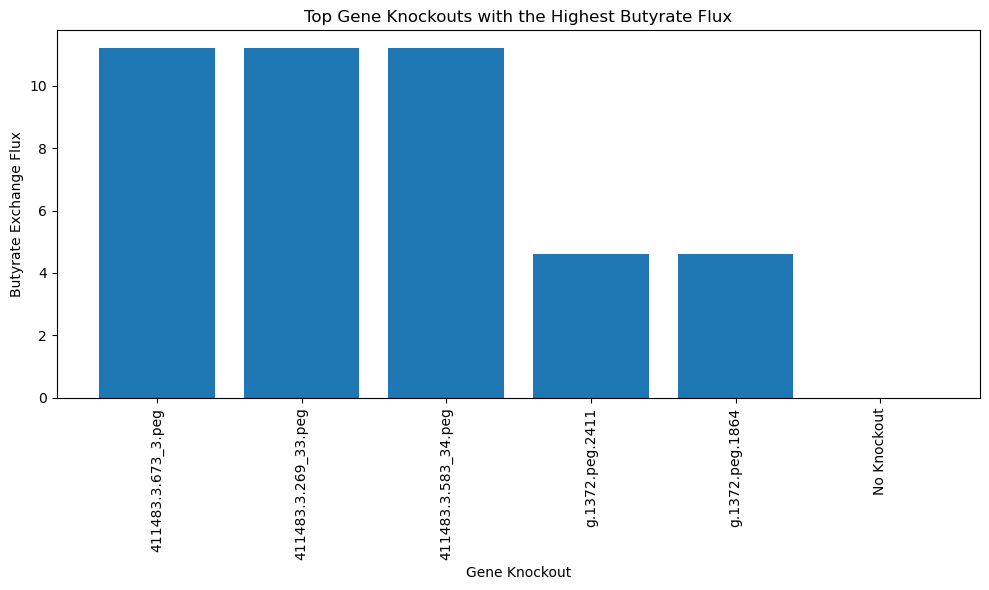

In [11]:
# Sort the results to find the top 10 knockouts with the lowest butyrate flux
fluxes_sorted_indices = sorted(range(len(fluxes)), key=lambda i: fluxes[i], reverse=True) #highest

# Add the "No Knockout" entry back to the top 10 list
top_10_indices = fluxes_sorted_indices[:6]

# Prepare the data for the bar chart
top_10_genes = [gene_knockouts[i] for i in top_10_indices]  # Include "No Knockout" as well
top_10_fluxes = [fluxes[i] for i in top_10_indices]

# Plot histogram of the top 10 knockouts including "No Knockout"
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
plt.bar(top_10_genes, top_10_fluxes)
plt.ylabel('Butyrate Exchange Flux')
plt.xlabel('Gene Knockout')
plt.title('Top Gene Knockouts with the Highest Butyrate Flux')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()